To hide the output use: ctrl+m+o

In [1]:
# window size
ws = 30
#
signiture_level = 5

TESTPERCENTAGE = 10 # percentage
epochs = 400

hidden_size = 128
num_layers = 3
batch_size = 10


In [2]:
import iisignature as iis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=3291398 sha256=547d3c00aa40437c07c0c91a4b69c5ae088a38b9f4690938b4d30af69994824e
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature


Load the database from google drive

In [3]:
import os
import numpy as np

train_data = "Train/SVC2004/"
files = os.listdir(train_data)
files = np.sort(files)

files = sorted(files, key=lambda x: x.split('S')[0])
for i in range(0, 1600, 40):
  files[i:i+40] = sorted(files[i:i+40], key=lambda x: int(x.split('S')[1][:-4]))
files[:10]

Mounted at /content/drive


['U1S1.TXT',
 'U1S2.TXT',
 'U1S3.TXT',
 'U1S4.TXT',
 'U1S5.TXT',
 'U1S6.TXT',
 'U1S7.TXT',
 'U1S8.TXT',
 'U1S9.TXT',
 'U1S10.TXT']

In [4]:
breakCount = -1
genuine = []
genuine_label = []
forgery = []
forgery_label = []
for file_name in files:
  file_data = np.loadtxt(train_data+file_name, skiprows=1)
  file_data = np.delete(file_data, np.s_[-5:], 1)  # only use the x,y coordinates
  file_data = np.rot90(file_data) # rotate the matrix

  split = file_name.split('S')
  label = [int(split[0][1:]), 1]
  if(int(split[1][:-4]) > 20): # skilled forgeries
    genuine_label.append(int(split[0][1:]))
    genuine.append(file_data)
  else:
    forgery_label.append(int(split[0][1:]))
    forgery.append(file_data)


  if(breakCount != -1 and file_name == files[breakCount]):
    break

genuine_label = np.array(genuine_label)
forgery_label = np.array(forgery_label)

Calculate the signiture.
Links: <br>
Short summary: https://github.com/bottler/phd-docs/blob/master/2016_cpeu4_may_neuralnets_chinese.pdf
<br>
iisigniture: https://github.com/bottler/iisignature, https://github.com/bottler/phd-docs/blob/master/iisignature.pdf
<br>
The math: https://arxiv.org/pdf/1603.03788.pdf, https://mathoverflow.net/questions/200405/understand-rough-path-iterated-integral-and-how-to-compute-it-numerically


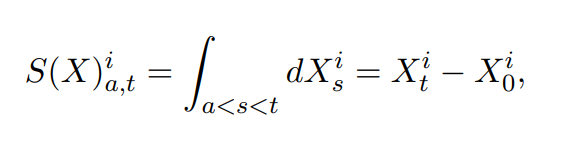

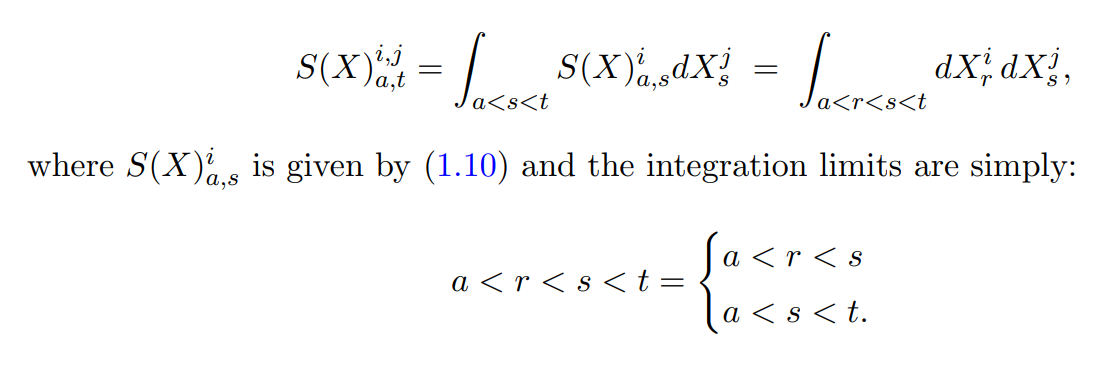

In [5]:
FEATURESIZE = iis.siglength(2, signiture_level)  # dim, sig_level

W = 2*ws + 1

def calcTimeSignitureSequence(raw_data):
  D = []
  for i in range(0, len(raw_data[0])-W):
    d = []
    for points in raw_data:  # goes from 0 to 1 (2 dims)
      index = W+i
      d.append(points[i:index])
    d = np.array(d).T
    signiture = iis.sig(d, signiture_level, 1)


    # Normalize the signiture
    l = raw_data.shape[1]
    L = np.array([l**i for i in range(1, signiture_level+1)])
    S = np.array([])
    for i in range(signiture_level):
      S = np.append(S, (signiture[i] / L[i]))
    
    D.append(S)
  return D


In [6]:
genuine_processed = []
for data in genuine:
  D = calcTimeSignitureSequence(data)
  genuine_processed.append(D)

forgery_processed = []
for data in forgery:
  D = calcTimeSignitureSequence(data)
  forgery_processed.append(D)

Normalize the data between 0-1.

In [7]:
from sklearn.preprocessing import StandardScaler

genuine_normalized = []
for f in genuine_processed:
  ss = StandardScaler()
  ss.fit(f)
  genuine_normalized.append(ss.transform(f))

forgery_normalized = []
for f in forgery_processed:
  ss = StandardScaler()
  ss.fit(f)
  forgery_normalized.append(ss.transform(f))

Based on this issue: https://github.com/keras-team/keras/issues/85  I need to create a padding with 0 to fill the empty space in the matrix

In [8]:
genuine_normalized[0].shape

(72, 62)

In [9]:
# Get the max shape
maxShape = 0 
for n in genuine_normalized:
    if n.shape[0] > maxShape:
      maxShape = n.shape[0]
for n in forgery_normalized:
    if n.shape[0] > maxShape:
      maxShape = n.shape[0]

maxShape

652

In [10]:
genuine_padded = []
for n in genuine_normalized:
  pad = np.pad(n, ((0, maxShape-n.shape[0]), (0, 0)), 'constant', constant_values=0)
  genuine_padded.append(pad)

genuine_padded = np.array(genuine_padded)
print("genuine shape: "+str(genuine_padded.shape))

forgery_padded = []
for n in forgery_normalized:
  pad = np.pad(n, ((0, maxShape-n.shape[0]), (0, 0)), 'constant', constant_values=0)
  forgery_padded.append(pad)

forgery_padded = np.array(forgery_padded)
print("genuine shape: "+str(forgery_padded.shape))

genuine shape: (800, 652, 62)
genuine shape: (800, 652, 62)


In [11]:
import torch
import torch.nn as nn
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
from sklearn.utils import shuffle

genuine_padded, genuine_label = shuffle(genuine_padded, genuine_label, random_state=42)
forgery_padded, forgery_label = shuffle(forgery_padded, forgery_label, random_state=42)

TESTNUM = int(genuine_padded.shape[0]*(TESTPERCENTAGE/100))

trainlen = genuine_padded.shape[0]-TESTNUM

genuine_test = genuine_padded[:TESTNUM]
genuine_padded = genuine_padded[TESTNUM:]
genuine_testLabel = genuine_label[:TESTNUM]
genuine_label = genuine_label[TESTNUM:]

forgery_test = forgery_padded[:TESTNUM]
forgery_padded = forgery_padded[TESTNUM:]
forgery_testLabel = forgery_label[:TESTNUM]
forgery_label = forgery_label[TESTNUM:]

In [13]:
print(genuine_padded.shape)
print(genuine_test.shape)

(720, 652, 62)
(80, 652, 62)


In [14]:
from torch.utils.data import DataLoader, Dataset
import random

input_size = genuine_padded.shape[2]

class DATA(Dataset):
  def __init__(self, genuine_data, forgery_data, genuine_labels, forgery_labels, is_train = True):
    self.genuine_data = genuine_data
    self.genuine_labels = genuine_labels
    self.forgery_data = forgery_data
    self.forgery_labels = forgery_labels
    self.is_train = is_train
  def __len__(self):
    return len(self.genuine_data)
  def __getitem__(self, item):
    anchor = self.genuine_data[item]

    if(self.is_train):
      anchor_label = self.genuine_labels[item]
      positive_indexes = [i for i in range(len(self.genuine_data)) if (self.genuine_labels[i] == anchor_label and i != item)]   
      negative_indexes = [i for i in range(len(self.forgery_data)) if (self.forgery_labels[i] == anchor_label and i != item)]

      positive_i = random.choice(positive_indexes)
      negative_i = random.choice(negative_indexes)

      return self.genuine_data[item], self.genuine_data[positive_i], self.forgery_data[negative_i]
    else:
      return self.genuine_data[item]

train_data = DATA(genuine_padded, forgery_padded, genuine_label, forgery_label)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = DATA(genuine_test, 0, 0, 0, False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [15]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.gru.flatten_parameters()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.linear = nn.Linear(self.hidden_size, 64)
        self.batch_size = batch_size
        

    def forward(self, x, h):
        #h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        
        out, _ = self.gru(x, h)
        out = self.linear(out)
        return out

    

model = GRUModel(input_size, hidden_size, num_layers, batch_size)
model = torch.jit.script(model).to(device)

In [16]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [17]:
import torch.optim as optim
optimizer = optim.Adamax(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

In [18]:
from tqdm.notebook import tqdm

model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
  for step, (anchor, positive, negative) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
    h0 = torch.zeros(num_layers, batch_size, hidden_size)
    h0 = h0.to(device)
    anchor = anchor.to(device, dtype=torch.float)
    positive = positive.to(device, dtype=torch.float)
    negative = negative.to(device, dtype=torch.float)

    optimizer.zero_grad()
    anchor_out = model(anchor, h0)
    positive_out = model(positive, h0)
    negative_out = model(negative, h0)

    loss = criterion(anchor_out, positive_out, negative_out)
    loss.backward()
    optimizer.step()



Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  return forward_call(*args, **kwargs)


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
def calc_euclidean(x1, x2):
    return np.linalg.norm(x1 - x2) # use this bc the above euc algo is not working with np


genuine = genuine_padded
genuine_data = DATA(genuine_padded, 0, genuine_label, 0, is_train=False)
genuine_loader = DataLoader(genuine_data, batch_size=1, shuffle=False)

out = []
for tensor in tqdm(genuine_loader):
    h0 = torch.zeros(num_layers, 1, hidden_size)
    h0 = h0.to(device)
    nnOut = model(tensor.to(device, dtype=torch.float), h0).detach().cpu().numpy()
    out.append(nnOut)

print(len(out))
r3 = 0
for i in tqdm(range(0, len(out)-1)):
  out1 = out[i]
  for j in range(i+1, len(out)):
    out2 = out[j]
    r3 = r3 + calc_euclidean(out1, out2)

  0%|          | 0/720 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  return forward_call(*args, **kwargs)


720


  0%|          | 0/719 [00:00<?, ?it/s]

In [20]:
def decision(test, genuine):
  N = len(genuine)
  r1 = (N-1)/2
  r2 = 0

  for gen in out:
    r2 = r2 + calc_euclidean(test, gen)

  return r1*r2/r3

def getFromLabel(label, padded):
  matching = []
  for i, l in enumerate(genuine_testLabel):
    if(l == label):
      matching.append(genuine_padded[i])
  return matching

def testing(labels, testSigs):
    res = []
    for i, testLabel in tqdm(enumerate(labels), total=len(labels)):
      h0 = torch.zeros(num_layers, 1, hidden_size)
      h0 = h0.to(device)
      sig = torch.from_numpy(testSigs[i].reshape((1, -1, testSigs[i].shape[1])))
      sig = sig.to(device, dtype=torch.float)
      output = model(sig, h0).detach().cpu().numpy()
      dec = decision(output, genuine_padded)
      res.append(dec)
    return res
    

print("Genuine: ")
genuine_res = testing(genuine_testLabel, genuine_test)


print("Forgery: ")
forgery_res = testing(forgery_testLabel, forgery_test)
  

print("Test count: " + str(len(genuine_testLabel) * 2))


Genuine: 


  0%|          | 0/80 [00:00<?, ?it/s]

0.8009770597638562
1.268772590813668
1.125134854797302
0.979788814821702
1.3327425289485133
1.1719802517525046
0.9371038014094107
0.9666788058845267
0.8784080774039436
0.8653843963799569
0.8818229853732197
1.0946696112442906
2.2686854962653213
0.8972572183619205
0.8466193910940867
0.886719958022087
1.1508169434805529
1.0999123958253356
0.83148529626326
1.0772591786348629
0.9961639726473104
1.0003606648222567
1.3911609886857468
0.8750778862238846
1.0053152120445943
0.8968968937071695
0.9203610716379457
0.9331648297889362
1.866430540006948
0.849262120877021
1.1496313454362004
1.0145690462073294
0.8415266440508455
1.0167172255530408
0.8806061226316743
2.0670211891074604
1.0235551524948896
0.972191192139083
0.8976754290558249
1.0821560275731985
1.5077117532380635
0.9000478104752324
1.1034629391842496
0.8896186881527619
0.9622206420217869
0.8981132551588206
0.9362169110808148
1.0377541423692103
1.228671212333032
0.9483849033911321
0.8261163657709067
1.2656095167311354
1.1662115878961887
0.8

  0%|          | 0/80 [00:00<?, ?it/s]

2.5584940499386444
2.8427819385196784
3.5850206235445503
2.9666978565838975
2.9164317109921836
1.3166673623775302
2.528682991815043
2.771652601209053
2.5395124019613964
1.6739563987684039
4.669749573419883
2.2507741390708196
1.7555579963745518
3.997914616619098
2.2845761697742035
2.2407046151149768
2.463313787963818
2.7630166670364105
2.318812946905299
2.3363069847376305
2.470813029160477
2.5687836017602406
2.2377192179377694
2.954051558025197
4.224375350335162
2.201921358442913
3.048737213842538
1.8582745907638698
1.8786026010031556
2.7226927541443127
1.5492326284135332
4.053567223654758
2.988928096543996
1.9840563823766082
3.077104932772952
2.3071835437199364
1.9520592599403646
2.08073243527027
2.828993254664538
2.3290106792401737
3.1591279011529165
3.885331081174377
3.2765522182485416
2.6100278155337744
2.1307093170571227
2.5134012195219295
1.4762224105189827
1.5686156454187272
2.0657546954424824
1.652216174828702
2.3881188196577443
2.903533423271016
2.548742288921726
3.249342402178

In [21]:
def testEfficiency(th):
    good = sum(i <= th for i in genuine_res)+sum(i > th for i in forgery_res)
    return good / (len(genuine_testLabel) * 2)

genuine_res.sort(reverse=True)
forgery_res.sort()

THRESHOLD = 1
best = 0
for i in genuine_res:
    eff = testEfficiency(i)
    if(eff>best):
        best = eff
        THRESHOLD = i
        
for i in forgery_res:
    eff = testEfficiency(i)
    if(eff>best):
        best = eff
        THRESHOLD = i


testEfficiency(THRESHOLD)


0.95

In [22]:
FP = 0
TP = 0
for i in genuine_res:
    if(i>THRESHOLD):
        FP = FP+1
    else:
        TP = TP+1

FN = 0
TN = 0
for i in forgery_res:
    if(i<=THRESHOLD):
        FN = FN+1
    else:
        TN = TN+1

FAR = FP / (FP + TN)
FRR = FN / (FN + TP)

print(FAR)
print(FRR)

0.06097560975609756
0.038461538461538464
